##### Copyright 2018 The TensorFlow Authors.

In [25]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with machine learning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [27]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

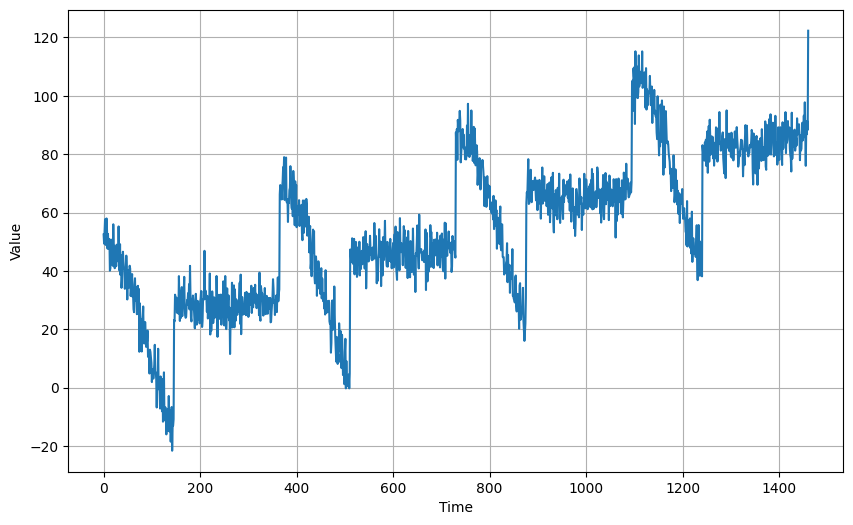

In [28]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

In [29]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [30]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear Model

In [31]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 1s 11ms/step - loss: 551.4951 - mae: 551.9951 - val_loss: 245.3316 - val_mae: 245.8316
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 917.2245 - mae: 917.7241 - val_loss: 1391.6974 - val_mae: 1392.1974
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 514.2938 - mae: 514.7936 - val_loss: 49.2993 - val_mae: 49.7993
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 263.2190 - mae: 263.7190 - val_loss: 1855.8864 - val_mae: 1856.3864
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 857.4695 - mae: 857.9695 - val_loss: 986.5067 - val_mae: 987.0067
Epoch 6/100
31/31 [==============================] - 0s 10ms/step - loss: 576.1492 - mae: 576.6492 - val_loss: 232.8535 - val_mae: 233.3535
Epoch 7/100
31/31 [==============================] - 0s 9ms/step - loss: 707.4622 - mae: 707.9622 - val_loss: 1649.6082 - val_mae: 1650.1082
Epoch 8/100
31/31 [==

In [34]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/500
31/31 [==============================] - 1s 11ms/step - loss: 659.8074 - mae: 660.3072 - val_loss: 2192.4348 - val_mae: 2192.9348
Epoch 2/500
31/31 [==============================] - 1s 11ms/step - loss: 645.7472 - mae: 646.2472 - val_loss: 392.9040 - val_mae: 393.4040
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 559.8856 - mae: 560.3856 - val_loss: 1167.3097 - val_mae: 1167.8097
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 764.5184 - mae: 765.0184 - val_loss: 686.3919 - val_mae: 686.8919
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 529.3221 - mae: 529.8221 - val_loss: 590.9162 - val_mae: 591.4162
Epoch 6/500
31/31 [==============================] - 0s 7ms/step - loss: 277.8090 - mae: 278.3090 - val_loss: 150.7013 - val_mae: 151.2013
Epoch 7/500
31/31 [==============================] - 0s 7ms/step - loss: 969.3992 - mae: 969.8992 - val_loss: 2987.4912 - val_mae: 2987.9912
Epoch 8/500
31/31 [

(1e-06, 0.001, 0.0, 20.0)

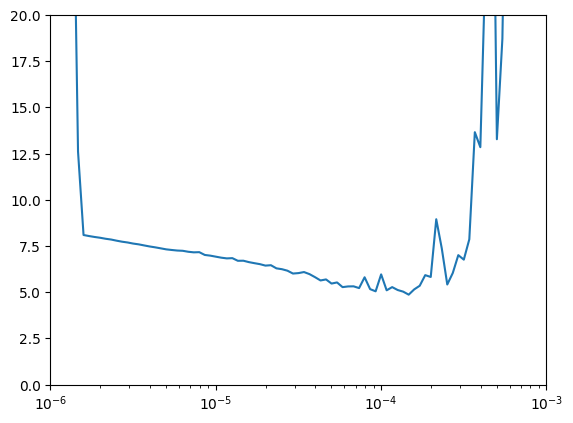

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=20)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 11ms/step - loss: 551.6542 - mae: 552.1541 - val_loss: 292.1886 - val_mae: 292.6886
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 448.1260 - mae: 448.6254 - val_loss: 35.6212 - val_mae: 36.1178
Epoch 3/500
31/31 [==============================] - 0s 9ms/step - loss: 329.6922 - mae: 330.1908 - val_loss: 293.0845 - val_mae: 293.5845
Epoch 4/500
31/31 [==============================] - 1s 14ms/step - loss: 579.4532 - mae: 579.9529 - val_loss: 1291.7047 - val_mae: 1292.2047
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 655.3699 - mae: 655.8695 - val_loss: 1082.2764 - val_mae: 1082.7764
Epoch 6/500
31/31 [==============================] - 0s 7ms/step - loss: 1144.3566 - mae: 1144.8566 - val_loss: 2275.8420 - val_mae: 2276.3420
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 770.3046 - mae: 770.8044 - val_loss: 1330.9744 - val_mae: 1331.4744
Epoch 8/500
31/31

In [11]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [12]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 [==============================] - 0s 5ms/step


In [13]:
lin_forecast.shape

(461,)

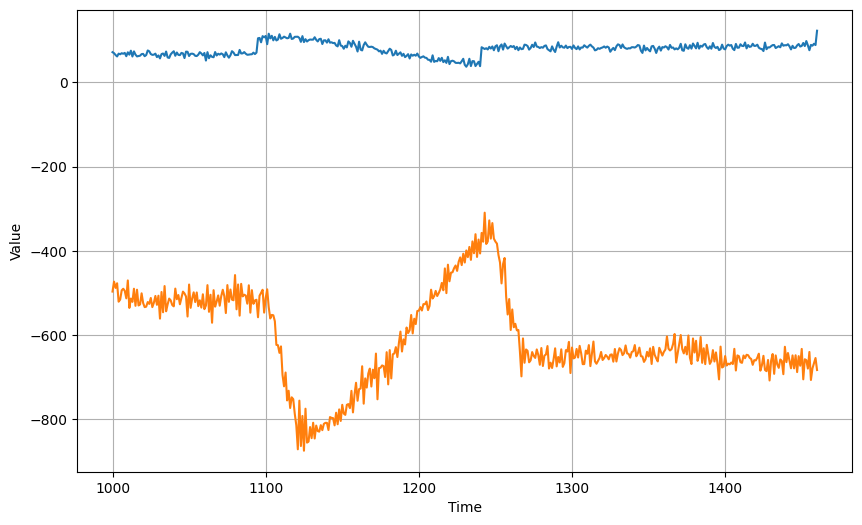

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [15]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

685.7956

### Dense Model Forecasting

In [35]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 42.5408 - mae: 43.0398 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 41.8920 - mae: 42.3907 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 41.0927 - mae: 41.5913 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 40.1867 - mae: 40.6856 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 39.1516 - mae: 39.6503 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 37.9638 - mae: 38.4624 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 36.5967 - mae: 37.0953 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 35.0213 - mae: 35.5200 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 33.2071 - mae: 33.7056 

(1e-07, 0.005, 0.0, 30.0)

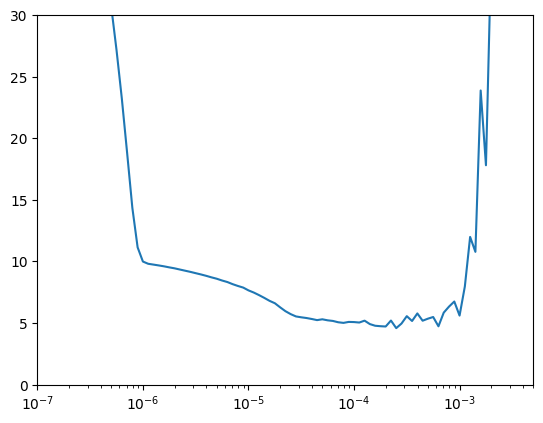

In [17]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=30)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 13ms/step - loss: 60.3048 - mae: 60.8030 - val_loss: 71.8426 - val_mae: 72.3426
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 21.3504 - mae: 21.8426 - val_loss: 35.2397 - val_mae: 35.7383
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 15.6937 - mae: 16.1850 - val_loss: 33.6487 - val_mae: 34.1480
Epoch 4/500
31/31 [==============================] - 0s 7ms/step - loss: 15.5032 - mae: 15.9969 - val_loss: 34.2575 - val_mae: 34.7567
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 46.3474 - mae: 46.8395 - val_loss: 63.1097 - val_mae: 63.6097
Epoch 6/500
31/31 [==============================] - 0s 9ms/step - loss: 26.4821 - mae: 26.9771 - val_loss: 73.6907 - val_mae: 74.1907
Epoch 7/500
31/31 [==============================] - 0s 9ms/step - loss: 36.9298 - mae: 37.4292 - val_loss: 71.1111 - val_mae: 71.6111
Epoch 8/500
31/31 [==============================] - 0

In [20]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 5ms/step


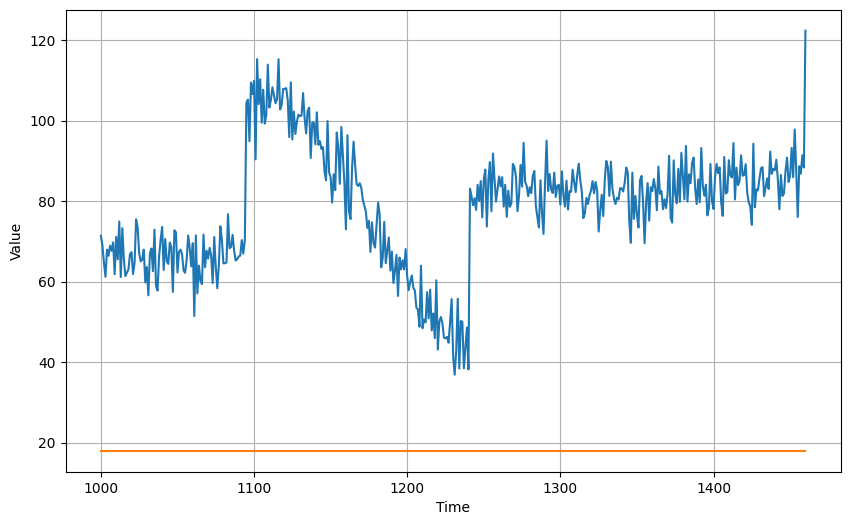

In [23]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [24]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

60.46363